In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

data=pd.read_csv('../input/train.csv')

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv', 'embeddings']


In [7]:
data.head()
print(data.shape)

(1306122, 3)


In [8]:
data[data['target']==1].head()

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


In [21]:
len(data[data['target']==1])/len(data['target'])

0.06187017751787352

In [20]:
data['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

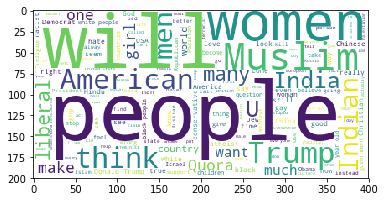

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
insincere_rows=data[data['target']==1]
wc=WordCloud(background_color='white').generate(' '.join(insincere_rows['question_text']))

plt.imshow(wc)

In [23]:
from sklearn.model_selection import train_test_split

train,validate=train_test_split(data,test_size=0.3,random_state=1)

train.shape,validate.shape

((914285, 3), (391837, 3))

In [27]:
import nltk
def clean_sentence(doc,stopwords,stemmer):
    words=doc.split(' ')
    words_clean=[stemmer.stem(word) for word in words if word not in stopwords]
    return ' '.join(words_clean)
def clean_documents(docs_raw):
    stopwords=nltk.corpus.stopwords.words('english')
    stemmer=nltk.stem.PorterStemmer()
    docs=docs_raw.str.lower().str.replace('[^a-z ]','')
    docs_clean=docs.apply(lambda doc:clean_sentence(doc,stopwords,stemmer))
    return docs_clean
train_docs_clean=clean_documents(train['question_text'])
train_docs_clean.head()

635414          inhand salari rd prc freshli join mt cil
906079                             one take yolo serious
99492                                  best club nairobi
973656    wake donald trump clock tick  hour return bodi
397612                              made elon musk smart
Name: question_text, dtype: object

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer(min_df=10).fit(train_docs_clean)

dtm=vectorizer.transform(train_docs_clean)

In [30]:
dtm.shape

(914285, 19550)

In [31]:
#pd.DataFrame(dtm.array())   ------>Memory Error

AttributeError: array not found

In [33]:
from sklearn.tree import DecisionTreeClassifier

model_df=DecisionTreeClassifier(max_depth=10).fit(dtm,train['target'])

In [35]:
validate_docs_clean = clean_documents(validate['question_text'])
dtm_validate= vectorizer.transform(validate_docs_clean)
dtm_validate

<391837x19550 sparse matrix of type '<class 'numpy.int64'>'
	with 2313528 stored elements in Compressed Sparse Row format>

In [38]:
predict=model_df.predict(dtm_validate)

In [36]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score

In [39]:
f1_score(validate['target'],predict)

0.2613359657782165

In [40]:
from sklearn.naive_bayes import MultinomialNB

nb=MultinomialNB().fit(dtm,train['target'])

validate_pred=nb.predict(dtm_validate)

f1_score(validate['target'],validate_pred)

0.5425968470252713

In [42]:
#from sklearn.model_selection import GridSearchCV

In [43]:
test=pd.read_csv('../input/test.csv')

docs_clean=clean_documents(test['question_text'])

dtm_test=vectorizer.transform(docs_clean)

dtm_test

<375806x19550 sparse matrix of type '<class 'numpy.int64'>'
	with 2220720 stored elements in Compressed Sparse Row format>

In [45]:
test_pred=nb.predict(dtm_test)

test_pred

array([1, 0, 0, ..., 0, 0, 0])

In [47]:
sam_sub=pd.read_csv('../input/sample_submission.csv')


submission=pd.DataFrame({'qid':test['qid'],'prediction':test_pred})


submission[['qid','prediction']].to_csv('submission.csv',index=False)